In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = "/content/drive/MyDrive/animal_dataset/"
import os
print(os.listdir(dataset_path))

['dog', 'cat', 'panda']


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import random

In [4]:
def load_images(folder):
    X = []
    y = []
    class_names = sorted(os.listdir(folder))

    for label, cls in enumerate(class_names):
        cls_folder = os.path.join(folder, cls)

        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg")):
                path = os.path.join(cls_folder, fname)

                img = Image.open(path).convert("L")
                img = img.resize((32, 32))
                arr = np.array(img, dtype=np.float32)

                X.append(arr.flatten())
                y.append(label)

    return np.array(X), np.array(y), class_names

X, y, class_names = load_images(dataset_path)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", class_names)

X shape: (300, 1024)
y shape: (300,)
Classes: ['cat', 'dog', 'panda']


In [5]:
def L2(x, X_train):
    return np.sqrt(np.sum((X_train - x)**2, axis=1))

def L1(x, X_train):
    return np.sum(np.abs(X_train - x), axis=1)

In [6]:
def knn_predict(x, X_train, y_train, k, metric="L2"):
    if metric == "L2":
        d = L2(x, X_train)
    else:
        d = L1(x, X_train)

    idx = np.argsort(d)[:k]
    labels = y_train[idx]

    return Counter(labels).most_common(1)[0][0]

In [7]:
def five_folds(X, y):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return np.array_split(idx, 5)

folds = five_folds(X, y)
print("5 fold created")

5 fold created


In [8]:
def evaluate_knn(X, y, Ks, metric="L2"):
    folds = five_folds(X, y)
    avg_acc = []

    for K in Ks:
        fold_acc = []
        for i in range(5):
            test_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(5) if j != i])

            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            correct = 0
            for x, true_label in zip(X_test, y_test):
                pred = knn_predict(x, X_train, y_train, K, metric)
                if pred == true_label:
                    correct += 1

            fold_acc.append(correct / len(test_idx))

        avg_acc.append(np.mean(fold_acc))
        print(f"K={K}, metric={metric}, accuracy={avg_acc[-1]:.4f}")

    return avg_acc

Ks = list(range(1, 20, 2))
acc_L2 = evaluate_knn(X, y, Ks, metric="L2")
acc_L1 = evaluate_knn(X, y, Ks, metric="L1")

K=1, metric=L2, accuracy=0.3367
K=3, metric=L2, accuracy=0.3900
K=5, metric=L2, accuracy=0.3567
K=7, metric=L2, accuracy=0.4000
K=9, metric=L2, accuracy=0.4067
K=11, metric=L2, accuracy=0.4200
K=13, metric=L2, accuracy=0.4367
K=15, metric=L2, accuracy=0.4400
K=17, metric=L2, accuracy=0.4100
K=19, metric=L2, accuracy=0.4100
K=1, metric=L1, accuracy=0.3600
K=3, metric=L1, accuracy=0.3967
K=5, metric=L1, accuracy=0.4433
K=7, metric=L1, accuracy=0.4367
K=9, metric=L1, accuracy=0.4567
K=11, metric=L1, accuracy=0.4400
K=13, metric=L1, accuracy=0.4433
K=15, metric=L1, accuracy=0.4367
K=17, metric=L1, accuracy=0.4633
K=19, metric=L1, accuracy=0.4500


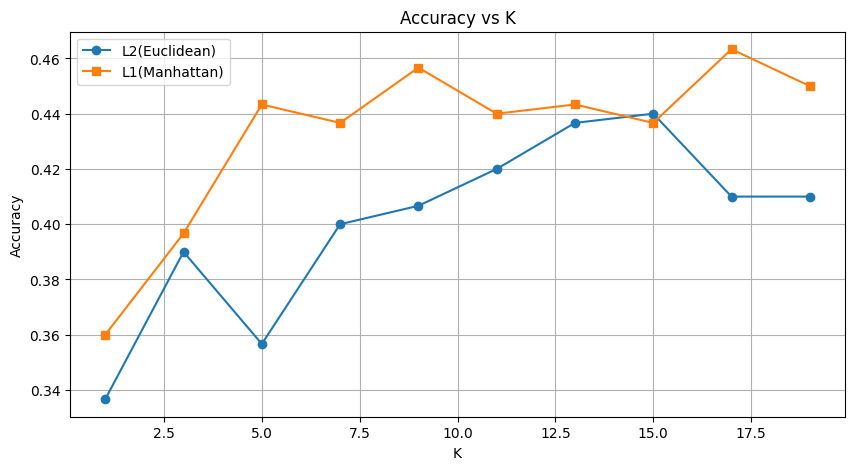

In [9]:
plt.figure(figsize=(10,5))
plt.plot(Ks, acc_L2, marker='o', label='L2(Euclidean)')
plt.plot(Ks, acc_L1, marker='s', label='L1(Manhattan)')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K")
plt.grid(True)
plt.legend()
plt.show()

### Discussion
From the results, we can see that the Manhattan distance (L1) performed slightly better than the Euclidean distance (L2) for this grayscale image dataset. For most of the K value, L1 gives higher accuracy, reaching up to 46%, while L2 peaks around 44%. This suggests that L1 handles pixel based features more effectively. As the raw images contain small variations and noise, L2 can overreact to these changes. But L1 treats them more evenly, making it more stable for images.

However, the overall accuracy for both methods is still moderate, which shows the limitation of using raw pixel values with KNN. To improve performance, feature extraction methods or more advanced models like CNNs could be used to capture more meaningful patterns.

In short, L1 distance is better suited for this dataset, but further improvements are needed to achieve stronger and more reliable classification accuracy.

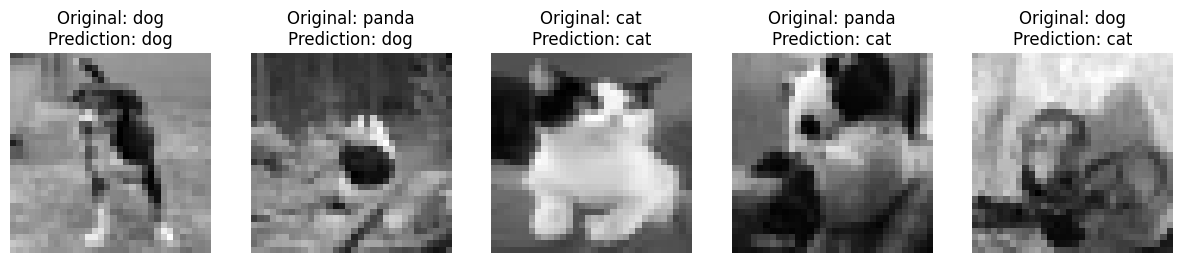

In [10]:
def show_top5(X, y, class_names, k=3, metric="L2"):
    plt.figure(figsize=(15,4))

    for i in range(5):
        idx = random.randint(0, len(X)-1)
        x = X[idx]

        mask = np.arange(len(X)) != idx
        X_train = X[mask]
        y_train = y[mask]

        pred = knn_predict(x, X_train, y_train, k, metric)

        plt.subplot(1,5,i+1)
        plt.imshow(x.reshape(32,32), cmap='gray')
        plt.title(f"Original: {class_names[y[idx]]}\nPrediction: {class_names[pred]}")
        plt.axis("off")

    plt.show()

show_top5(X, y, class_names, k=3, metric="L2")